# Chem 277B Spring 2024 Tutorial 9
---
## Outline
1. Savio Account Setup
2. Data structure of ANI dataset
3. Atomic environment vector (AEV) calculator
4. General suggestions for final project

## References
+ ANI-1: an extensible neural network potential with DFT accuracy at force field computational cost<br> ([Article](https://pubs.rsc.org/en/content/articlepdf/2017/sc/c6sc05720a), [Supplement](http://www.rsc.org/suppdata/c6/sc/c6sc05720a/c6sc05720a1.pdf), [Dataset](https://doi.org/10.6084/m9.figshare.c.3846712.v1)),

# 1. Savio Account Setup

* Create a MyBRC portal account at https://mybrc.brc.berkeley.edu/ ([Instruction](https://docs-research-it.berkeley.edu/services/high-performance-computing/getting-account/#setting-up-a-mybrc-user-portal-account))
* Search for project named `ic_chem277b` and join. There will be a processing wait time of a few days for new users!

* Logging in and One-Time Password (OTP) setup [instruction](https://docs-research-it.berkeley.edu/services/high-performance-computing/user-guide/logging-brc-clusters/)

* Access jupyter notebook on Savio [instruction](https://docs-research-it.berkeley.edu/services/high-performance-computing/user-guide/ood/jupyter/)

We will cover more about requesting gpu nodes and submitting jobs next time. Stay Tuned!

# 2. Data structure of ANI dataset
Might need `pip install h5py`

In [2]:
from pyanitools import anidataloader

# Set the HDF5 file containing the data
hdf5file = 'ani_gdb_s01.h5'

# Construct the data loader class
data_loader = anidataloader(hdf5file)

# Print the species of the data set one by one
for data in data_loader:

    # Extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # Print the data
    print("Path:   ", P)
    print("  Smiles:      ","".join(sm))
    print("  Symbols:     ", S)
    print("  Coordinates: ", X.shape)
    print("  Energies:    ", E.shape, "\n")

# Closes the H5 data file
data_loader.cleanup()

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

Path:    /gdb11_s01/gdb11_s01-1
  Smiles:       [H]N([H])[H]
  Symbols:      ['N', 'H', 'H', 'H']
  Coordinates:  (3600, 4, 3)
  Energies:     (3600,) 

Path:    /gdb11_s01/gdb11_s01-2
  Smiles:       [H]O[H]
  Symbols:      ['O', 'H', 'H']
  Coordinates:  (1800, 3, 3)
  Energies:     (1800,) 



How many molecules and conformations are there?

In [3]:
data_loader = anidataloader(hdf5file)

count = 0
count_conf = 0
for data in data_loader:
    count+=1
    count_conf += len(data['energies'])
print(count)
print(count_conf)

data_loader.cleanup()

3
10800


# 3. Atomic environment vector (AEV) calculator
## Processing Data with AEV Representation

In [4]:
import numpy as np


def calc_f_C(Rij, RC):
    f_C_value = 0.5 * np.cos(np.pi * Rij / RC) + 0.5
    # Make f_C(0)=0 to make sure the sum in distance conversion function 
    # and radial conversion function can run with j=i
    indicator = ((Rij <= RC) & (Rij != 0)).astype(float) 
    return f_C_value * indicator
    

def radial_component(Rijs, eta, Rs, RC=5.2):
    # Rijs is a 1d array, all other parameters are scalars
    f_C_values = calc_f_C(Rijs, RC)
    individual_components = np.exp(-eta * (Rijs - Rs) ** 2) * f_C_values
    return np.sum(individual_components)

def angular_component(Rij_vectors, Rik_vectors, zeta, theta_s, eta, Rs, RC=3.5):
    # Rij_vectors and Rik_vectors are 2d arrays with shape (n_atoms, 3), all other parameters are scalars
    # calculate theta_ijk values from vector operations
    dot_products = Rij_vectors.dot(Rik_vectors.T)
    Rij_norms = np.linalg.norm(Rij_vectors, axis=-1)
    Rik_norms = np.linalg.norm(Rik_vectors, axis=-1)
    norms = Rij_norms.reshape((-1, 1)).dot(Rik_norms.reshape((1, -1)))
    cos_values = np.clip(dot_products / (norms + 1e-8), -1, 1)
    theta_ijks = np.arccos(cos_values)
    theta_ijk_filter = (theta_ijks != 0).astype(float)
    mean_dists = (Rij_norms.reshape((-1, 1)) + Rik_norms.reshape((1, -1))) / 2
    f_C_values_Rij = calc_f_C(Rij_norms, RC)
    f_C_values_Rik = calc_f_C(Rik_norms, RC)
    f_C_values = f_C_values_Rij.reshape((-1, 1)).dot(f_C_values_Rik.reshape((1, -1)))
    individual_components = (1 + np.cos(theta_ijks - theta_s)) ** zeta * \
        np.exp(-eta * (mean_dists - Rs) ** 2) * f_C_values * theta_ijk_filter
    return 2 ** (1 - zeta) * np.sum(individual_components)

def calc_aev(atom_types, coords, i_index):
    # atom_types are np.array of ints
    relative_coordinates = coords - coords[i_index]
    nearby_atom_indicator = np.linalg.norm(relative_coordinates, axis=-1) < 5.3
    relative_coordinates = relative_coordinates[nearby_atom_indicator]
    atom_types = atom_types[nearby_atom_indicator]
    radial_aev = np.array([radial_component(np.linalg.norm(relative_coordinates[atom_types == atom], 
                                                           axis=-1), eta, Rs) \
                           for atom in [0, 1, 2, 3] for eta in [16] \
                           for Rs in [0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,\
                                   3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250]])
    angular_aev = np.array([angular_component(relative_coordinates[atom_types == atom_j], 
                                              relative_coordinates[atom_types == atom_k],\
                                             zeta, theta_s, eta, Rs) \
                            for atom_j in [0, 1, 2, 3] for atom_k in range(atom_j, 4) for zeta in [32] \
                            for theta_s in [0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]\
                            for eta in [8] for Rs in [0.900000,1.550000,2.200000,2.850000]])
    print(len(radial_aev), len(angular_aev))
    return np.concatenate([radial_aev, angular_aev])

In [5]:
mapping={"H":0, "C":1, "N":2, "O":3}
elements= np.array([mapping[atom] for atom in S])
elements

array([3, 0, 0])

64 320
64 320


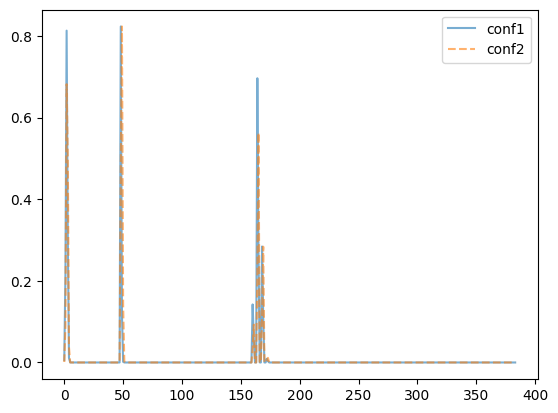

In [6]:
import matplotlib.pyplot as plt

plt.plot(calc_aev(elements, X[0], 2), label="conf1", alpha=0.6)
plt.plot(calc_aev(elements, X[10], 2), label="conf2", alpha=0.6, ls="--")
plt.legend()

## AEV implementation in pytorch - torchani
https://github.com/aiqm/torchani.git

In [7]:
import torchani
import torch

Rcr = 5.2
Rca = 3.5
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,\
                            3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250], dtype=torch.float)
EtaA= torch.tensor([8], dtype=torch.float)
Zeta = torch.tensor([32], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243], 
                    dtype=torch.float)
num_species = 4
aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, 
                                    ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)

/Users/chu/miniconda3/envs/chem277b/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/Users/chu/miniconda3/envs/chem277b/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


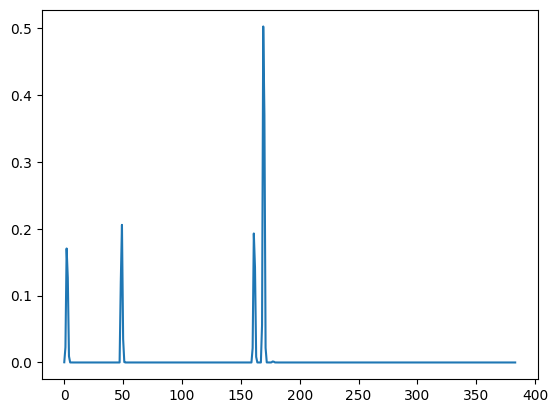

In [8]:
aevs = aev_computer.forward((torch.tensor(elements.reshape(1, -1), dtype=torch.long), 
                             torch.tensor(X[10].reshape(1, -1, 3), dtype=torch.float)))
plt.plot(aevs[1].numpy()[0, 2])

# 4. General suggestions for final project
* Read the paper
    * Atomic "self energies" are subtracted from the molecular energies; thus we are effectively learning the energy difference to a reference state.
* Test the workflow on small amount of data first (up to 2 heavy atoms)
* Tuning hyperparameters and finalizing architecture with a little more data.
* Final production run on full data ( to be defined based on resource to be provided)
* Save intermediate result!!! (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
